In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time


In [5]:
data = pd.read_excel("owid-covid-data.xlsx")

In [7]:
# picking out our 10 countries that have relatively low missingness and that are adjacent 
country_list = ['Norway', 'Finland', 'Lithuania', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Denmark', 'Switzerland', 'Poland']
selected_data = data[data['location'].isin(country_list)]
selected_data.head()


iso_code continent location        date  total_cases  new_cases  \
28497      BEL    Europe  Belgium  2020-01-03          NaN        0.0   
28498      BEL    Europe  Belgium  2020-01-04          NaN        0.0   
28499      BEL    Europe  Belgium  2020-01-05          NaN        0.0   
28500      BEL    Europe  Belgium  2020-01-06          NaN        0.0   
28501      BEL    Europe  Belgium  2020-01-07          NaN        0.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
28497                 NaN           NaN         0.0                  NaN  ...   
28498                 NaN           NaN         0.0                  NaN  ...   
28499                 NaN           NaN         0.0                  NaN  ...   
28500                 NaN           NaN         0.0                  NaN  ...   
28501                 NaN           NaN         0.0                  NaN  ...   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
28497          31.4                     NaN                        5.64   
28498          31.4                     NaN                        5.64   
28499          31.4                     NaN                        5.64   
28500          31.4                     NaN                        5.64   
28501          31.4                     NaN                        5.64   

       life_expectancy  human_development_index  population  \
28497            81.63                    0.931    11655923   
28498            81.63                    0.931    11655923   
28499            81.63                    0.931    11655923   
28500            81.63                    0.931    11655923   
28501            81.63                    0.931    11655923   

       excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
28497                                   NaN                          NaN   
28498                                   NaN                          NaN   
28499                                -151.3                        -6.34   
28500                                   NaN                          NaN   
28501                                   NaN                          NaN   

       excess_mortality  excess_mortality_cumulative_per_million  
28497               NaN                                      NaN  
28498               NaN                                      NaN  
28499             -6.34                               -13.086293  
28500               NaN                                      NaN  
28501               NaN                                      NaN  

[5 rows x 67 columns]

## Data Prep

### Removing irrelevant dates


Dates to remove specified in ARIMA file.

In [8]:
# Subset the dataset
data_clean = selected_data[(selected_data['date'] >= '2020-03-01') & (selected_data['date'] <= '2023-01-15')]

In [9]:
# check missingness
missing_values_count = data_clean['new_cases'].isnull().sum()
print(missing_values_count)

0


### Removing variables

#### Dropping more than 30% missingness

In [10]:

# create a table that shows the number of features with more than 30% missing values for each country
def missing_features_by_country(df):

    missingness = df.groupby('location').apply(lambda group: group.isna().mean() * 100)
    
    # Count the number of features with more than 30% missing values for each country
    features_missing_30 = (missingness > 30).sum(axis=1)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Country': features_missing_30.index,
        'Features with >30% Missingness': features_missing_30.values
    })
    
    return summary.sort_values(by='Features with >30% Missingness', ascending=True)

# Calculate and display the results
missing_features_summary = missing_features_by_country(data_clean)
print(missing_features_summary)

          Country  Features with >30% Missingness
4           Italy                               7
0         Belgium                               9
8     Switzerland                              13
1         Denmark                              16
3         Ireland                              16
2         Finland                              19
9  United Kingdom                              20
5       Lithuania                              22
6          Norway                              26
7          Poland                              27


In [11]:
#data missingness
missing_data = data_clean.isnull().sum()
threshold = 0.3 * len(data_clean)
missing_data = missing_data[missing_data < threshold]
missing_data

iso_code                              0
continent                             0
location                              0
date                                  0
total_cases                          25
new_cases                             0
new_cases_smoothed                    0
total_deaths                         81
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million              25
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million             81
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                   223
hosp_patients                      2499
hosp_patients_per_million          2499
total_tests                        3023
new_tests                          3146
total_tests_per_thousand           3023
new_tests_per_thousand             3146
new_tests_smoothed                 2365
new_tests_smoothed_per_thousand    2365


In [12]:
# drop features with >30% missingness
threshold = 0.7 * len(selected_data)

data_clean = data_clean.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

#### Removing constants

In [22]:

# Assuming 'df' is your DataFrame
df_grouped = data_clean.groupby('location')

threshold = 0.95

# For each location after grouping
constant_columns_by_location = df_grouped.apply(lambda group: group.columns[group.apply(lambda col: col.value_counts(normalize=True).max() >= threshold)])

constant_columns_df = constant_columns_by_location.reset_index(name='cons_variables')


print(constant_columns_df['cons_variables'].iloc[0])

Index(['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')


Constant Variables:

['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

Keeping location though!

In [23]:
variables_to_remove = ['iso_code', 'continent', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

data_clean_subset = data_clean.drop(columns=variables_to_remove)
data_clean_subset.columns



Index(['location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'stringency_index'],
      dtype='object')

Still need to remove all the totals and smoothers: 'total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million'

In [24]:
remove = ['total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 
          'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']

data_clean_subset = data_clean_subset.drop(columns=remove)
data_clean_subset.columns


Index(['location', 'date', 'new_cases', 'new_deaths', 'reproduction_rate',
       'stringency_index'],
      dtype='object')

In [25]:
data_clean_subset.head()

location        date  new_cases  new_deaths  reproduction_rate  \
28555  Belgium  2020-03-01        0.0         0.0                NaN   
28556  Belgium  2020-03-02        0.0         0.0                NaN   
28557  Belgium  2020-03-03       18.0         0.0                NaN   
28558  Belgium  2020-03-04       19.0         0.0                NaN   
28559  Belgium  2020-03-05       34.0         0.0                NaN   

       stringency_index  
28555             11.11  
28556             11.11  
28557             11.11  
28558             13.89  
28559             13.89

#### Testing for Multicollinearity

In [26]:
## date as index
# Convert 'ds' to datetime if it's not already

data_clean_subset['date'] = pd.to_datetime(data_clean['date'])

data_clean_subset.set_index('date', inplace=True)

In [27]:
data_clean_subset.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0                NaN   
2020-03-02  Belgium        0.0         0.0                NaN   
2020-03-03  Belgium       18.0         0.0                NaN   
2020-03-04  Belgium       19.0         0.0                NaN   
2020-03-05  Belgium       34.0         0.0                NaN   

            stringency_index  
date                          
2020-03-01             11.11  
2020-03-02             11.11  
2020-03-03             11.11  
2020-03-04             13.89  
2020-03-05             13.89

<Axes: >

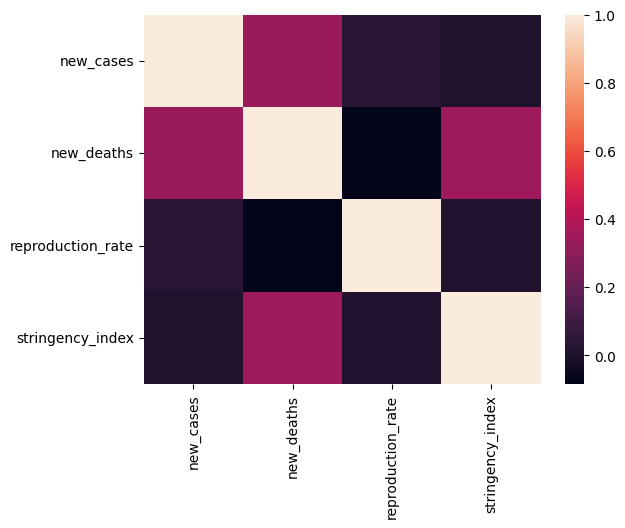

In [17]:
for_corr = data_clean_subset.copy().drop(columns=['location'])
correlation = for_corr.corr( method='pearson' )
sns.heatmap( correlation )

Pretty good on collinearity, can move forward with these variables.

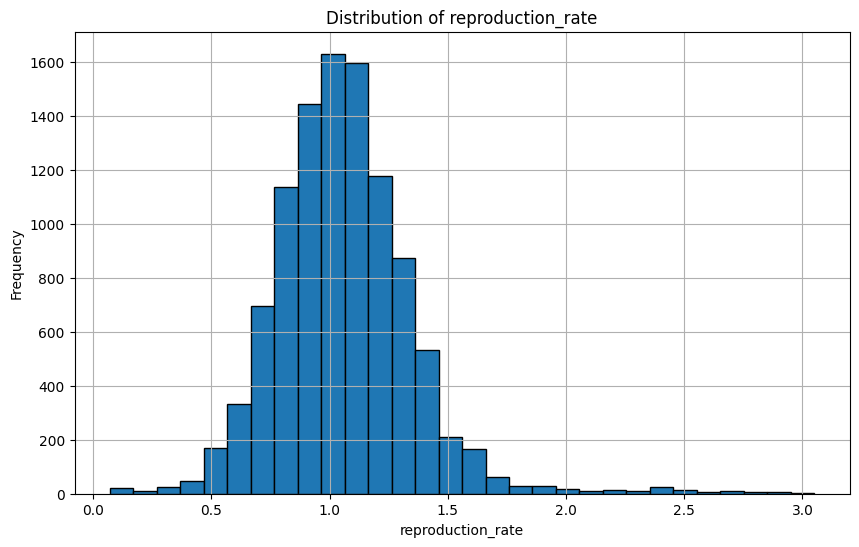

In [18]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'reproduction_rate'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

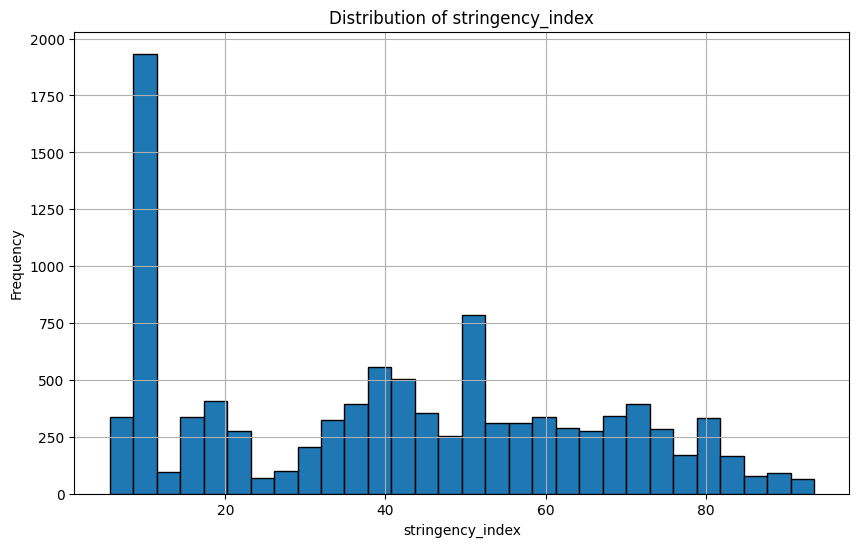

In [19]:
# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'stringency_index'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

#### Dealing with Outliers

In [29]:
data_clean_subset.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0                NaN   
2020-03-02  Belgium        0.0         0.0                NaN   
2020-03-03  Belgium       18.0         0.0                NaN   
2020-03-04  Belgium       19.0         0.0                NaN   
2020-03-05  Belgium       34.0         0.0                NaN   

            stringency_index  
date                          
2020-03-01             11.11  
2020-03-02             11.11  
2020-03-03             11.11  
2020-03-04             13.89  
2020-03-05             13.89

In [30]:
na_counts = data_clean_subset.isna().sum()
print(na_counts)

location               0
new_cases              0
new_deaths             0
reproduction_rate    223
stringency_index     150
dtype: int64


In [52]:
from scipy import stats
import numpy as np

# Select only numeric columns
numeric_columns = data_clean_subset.select_dtypes(include='number')

# Calculate z-scores for each numeric column
z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for outlier detection
threshold = 4

# Replace outliers in numeric columns with NaN
data_clean_no_outliers = data_clean_subset.copy()
data_clean_no_outliers[numeric_columns.columns] = np.where(z_scores >= threshold, np.nan, data_clean_subset[numeric_columns.columns])

data_clean_no_outliers.head()



location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0                NaN   
2020-03-02  Belgium        0.0         0.0                NaN   
2020-03-03  Belgium       18.0         0.0                NaN   
2020-03-04  Belgium       19.0         0.0                NaN   
2020-03-05  Belgium       34.0         0.0                NaN   

            stringency_index  
date                          
2020-03-01             11.11  
2020-03-02             11.11  
2020-03-03             11.11  
2020-03-04             13.89  
2020-03-05             13.89

In [53]:
na_counts = data_clean_no_outliers.isna().sum()
print(na_counts)

location               0
new_cases            129
new_deaths           146
reproduction_rate    223
stringency_index     150
dtype: int64


I want to use forward fill to impute new_cases and new_deaths, and impute the other two with the mean

In [54]:
# Forward fill new_cases and new_deaths
data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)

# Impute reproduction_rate and stringency_index with mean
mean_reproduction_rate = data_clean_no_outliers['reproduction_rate'].mean()
mean_stringency_index = data_clean_no_outliers['stringency_index'].mean()

data_clean_no_outliers['reproduction_rate'].fillna(mean_reproduction_rate, inplace=True)
data_clean_no_outliers['stringency_index'].fillna(mean_stringency_index, inplace=True)

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_26611/4103382970.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_26611/4103382970.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)


In [55]:
data_clean_no_outliers.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   

            stringency_index  
date                          
2020-03-01             11.11  
2020-03-02             11.11  
2020-03-03             11.11  
2020-03-04             13.89  
2020-03-05             13.89

## Feature Engineering

### Creating Lag Features

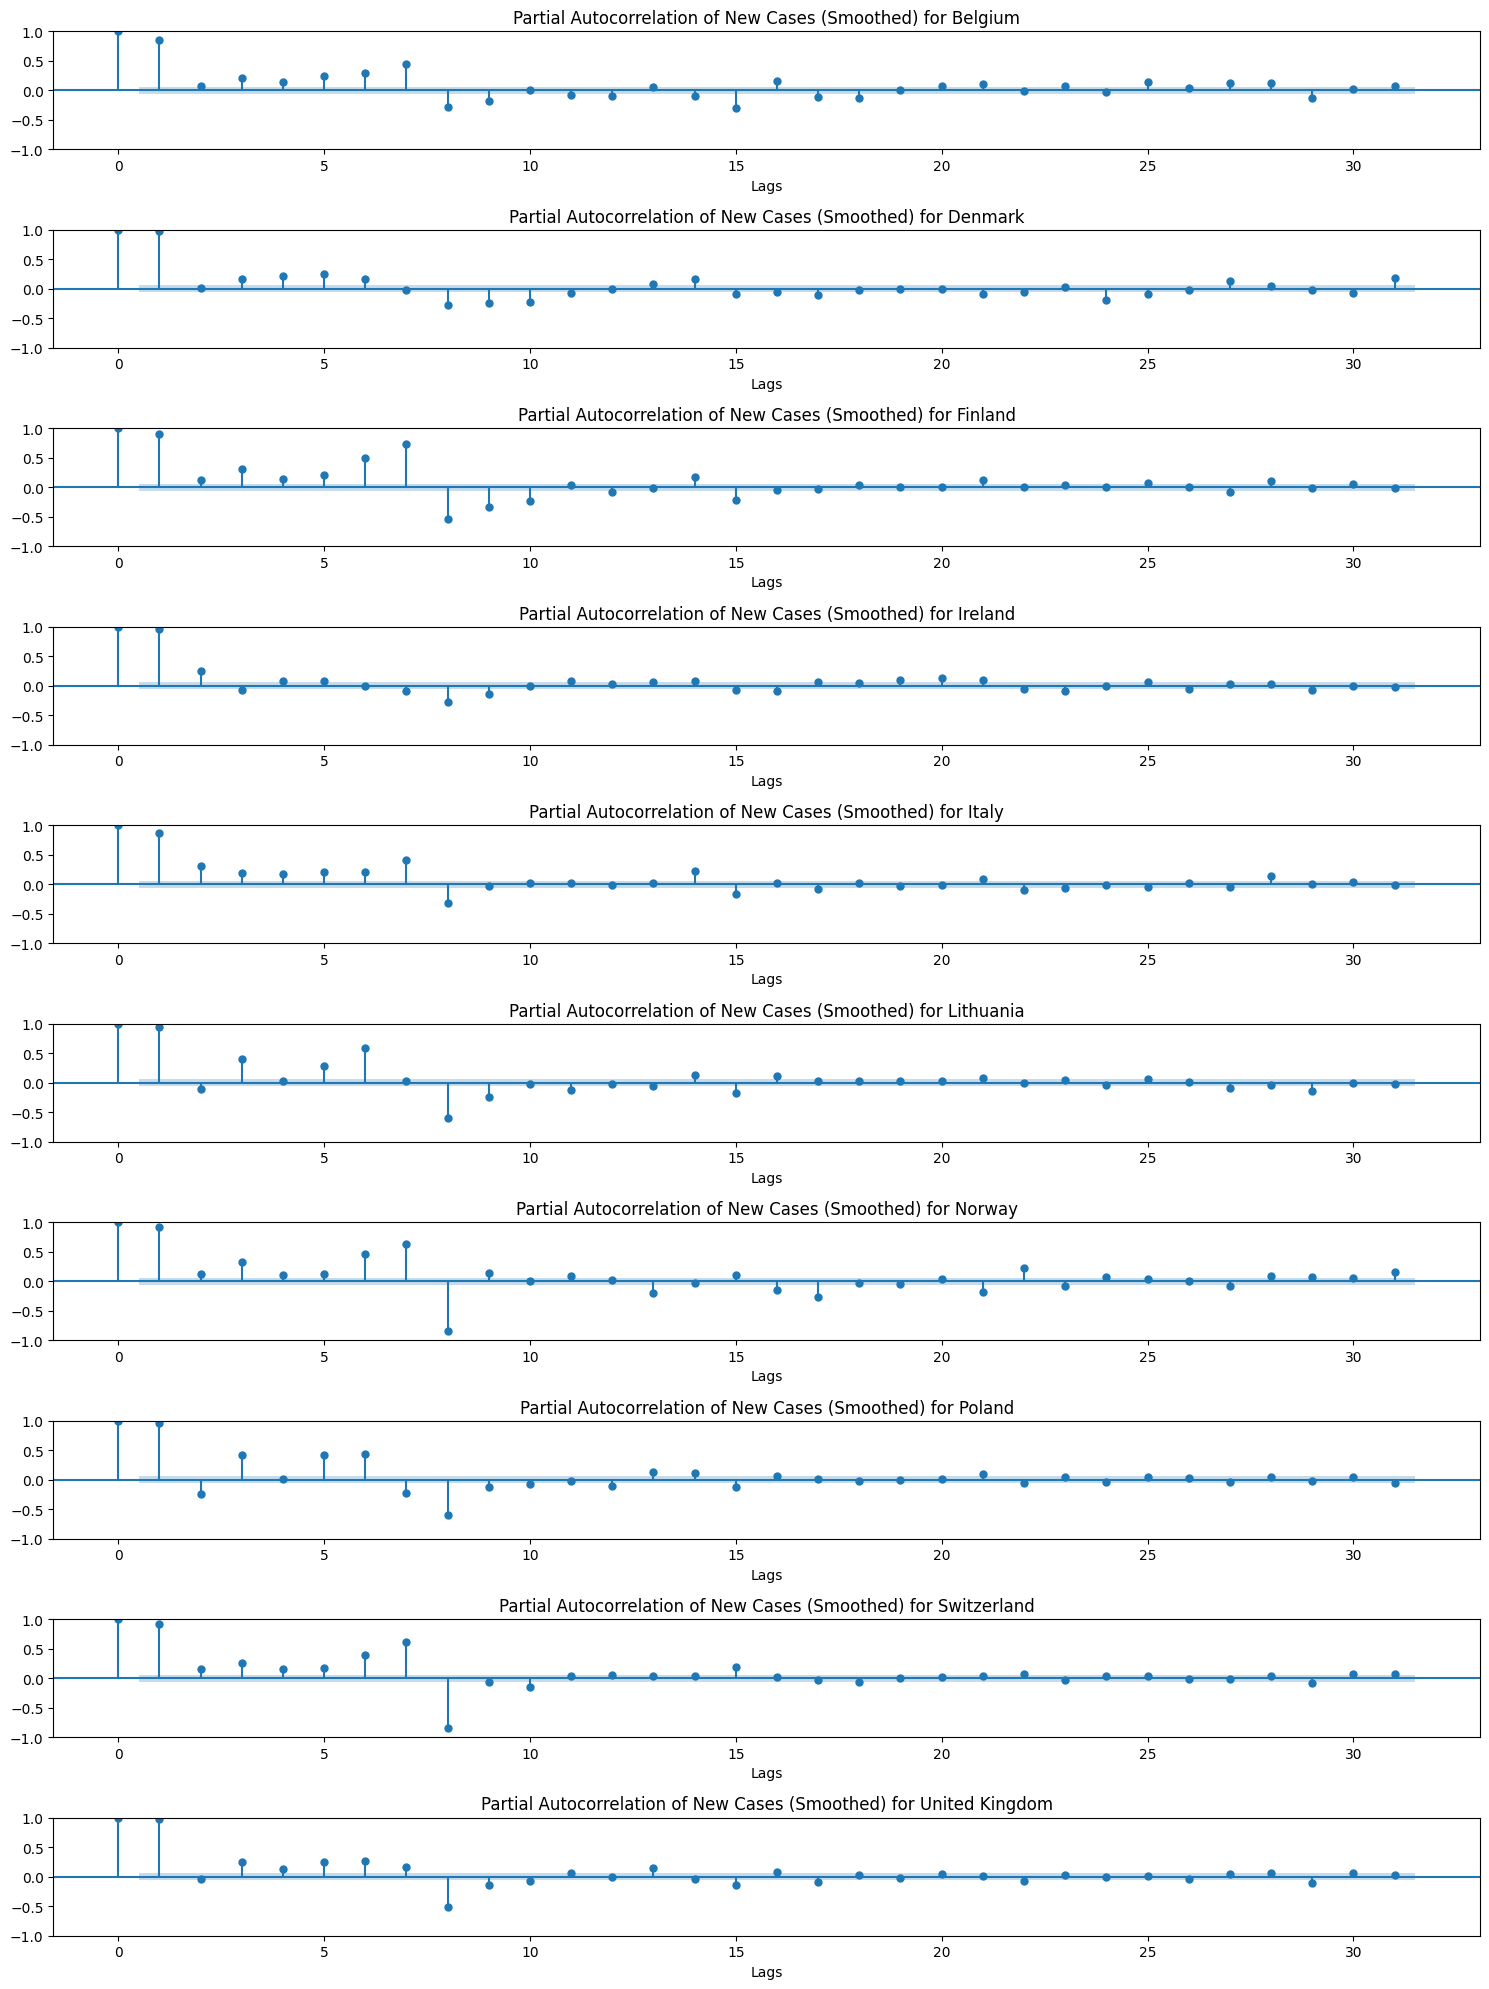

In [35]:
### Examining PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = data_clean_no_outliers['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = data_clean_no_outliers[data_clean_no_outliers['location'] == country]['new_cases']
    plot_pacf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

Spikes at lags 1 and 8, adding lags at 1 and 8.

In [56]:
data_clean_lag = data_clean_no_outliers.copy()

for lag in [1, 8]:
    data_clean_lag[f'new_cases_lag{lag}'] = data_clean_lag['new_cases'].shift(lag)

data_clean_lag.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   

            stringency_index  new_cases_lag1  new_cases_lag8  
date                                                          
2020-03-01             11.11             NaN             NaN  
2020-03-02             11.11             0.0             NaN  
2020-03-03             11.11             0.0             NaN  
2020-03-04             13.89            18.0             NaN  
2020-03-05             13.89            19.0             NaN

### Creating Rolling Mean Features

In [57]:
data_clean_roll_mean = data_clean_lag.copy()
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    data_clean_roll_mean[f'new_cases_roll_mean{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).mean()
    data_clean_roll_mean[f'new_cases_roll_std{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).std()

data_clean_roll_mean.head(10)

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   
2020-03-06  Belgium       53.0         0.0           1.058986   
2020-03-07  Belgium       81.0         0.0           2.430000   
2020-03-08  Belgium      110.0         0.0           2.410000   
2020-03-09  Belgium       27.0         1.0           2.410000   
2020-03-10  Belgium       64.0         0.0           2.400000   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01             11.11             NaN             NaN   
2020-03-02             11.11             0.0             NaN   
2020-03-03             11.11             0.0             NaN   
2020-03-04             13.89            18.0             NaN   
2020-03-05             13.89            19.0             NaN   
2020-03-06             13.89            34.0             NaN   
2020-03-07             13.89            53.0             NaN   
2020-03-08             13.89            81.0             NaN   
2020-03-09             13.89           110.0             0.0   
2020-03-10             19.44            27.0             0.0   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01                   NaN                  NaN                    NaN   
2020-03-02                   NaN                  NaN                    NaN   
2020-03-03                   NaN                  NaN                    NaN   
2020-03-04                   NaN                  NaN                    NaN   
2020-03-05                   NaN                  NaN                    NaN   
2020-03-06                   NaN                  NaN                    NaN   
2020-03-07             29.285714            29.460223                    NaN   
2020-03-08             45.000000            39.021362                    NaN   
2020-03-09             48.857143            34.954392                    NaN   
2020-03-10             55.428571            32.418396                    NaN   

            new_cases_roll_std14  
date                              
2020-03-01                   NaN  
2020-03-02                   NaN  
2020-03-03                   NaN  
2020-03-04                   NaN  
2020-03-05                   NaN  
2020-03-06                   NaN  
2020-03-07                   NaN  
2020-03-08                   NaN  
2020-03-09                   NaN  
2020-03-10                   NaN

### Creating Time Features

#### Holidays and Seasons

In [59]:
import holidays

## changing date back to column
data_add_time = data_clean_roll_mean.reset_index()
data_add_time['date'] = pd.to_datetime(data_add_time['date'])

# Define the country for which you want to check holidays (e.g., 'US' for United States)
country_code = 'US'

# Get the list of holidays for the specified country
holiday_list = holidays.UnitedStates(years=data_add_time['date'].dt.year)

# Create a new column 'is_holiday' and set the values based on whether the date is a holiday or not
data_add_time['is_holiday'] = data_add_time['date'].isin(holiday_list).astype(int)
# Add a new column 'is_holiday' based on whether the date is a holiday
data_add_time.head(20)



date location  new_cases  new_deaths  reproduction_rate  \
0  2020-03-01  Belgium        0.0         0.0           1.058986   
1  2020-03-02  Belgium        0.0         0.0           1.058986   
2  2020-03-03  Belgium       18.0         0.0           1.058986   
3  2020-03-04  Belgium       19.0         0.0           1.058986   
4  2020-03-05  Belgium       34.0         0.0           1.058986   
5  2020-03-06  Belgium       53.0         0.0           1.058986   
6  2020-03-07  Belgium       81.0         0.0           2.430000   
7  2020-03-08  Belgium      110.0         0.0           2.410000   
8  2020-03-09  Belgium       27.0         1.0           2.410000   
9  2020-03-10  Belgium       64.0         0.0           2.400000   
10 2020-03-11  Belgium       94.0         0.0           2.410000   
11 2020-03-12  Belgium       99.0         1.0           2.410000   
12 2020-03-13  Belgium      174.0         3.0           2.430000   
13 2020-03-14  Belgium      250.0         0.0           2.400000   
14 2020-03-15  Belgium      338.0         4.0           2.380000   
15 2020-03-16  Belgium      179.0         7.0           2.350000   
16 2020-03-17  Belgium      214.0         7.0           2.310000   
17 2020-03-18  Belgium      387.0        11.0           2.280000   
18 2020-03-19  Belgium      422.0        15.0           2.240000   
19 2020-03-20  Belgium      534.0        25.0           2.200000   

    stringency_index  new_cases_lag1  new_cases_lag8  new_cases_roll_mean7  \
0              11.11             NaN             NaN                   NaN   
1              11.11             0.0             NaN                   NaN   
2              11.11             0.0             NaN                   NaN   
3              13.89            18.0             NaN                   NaN   
4              13.89            19.0             NaN                   NaN   
5              13.89            34.0             NaN                   NaN   
6              13.89            53.0             NaN             29.285714   
7              13.89            81.0             NaN             45.000000   
8              13.89           110.0             0.0             48.857143   
9              19.44            27.0             0.0             55.428571   
10             19.44            64.0            18.0             66.142857   
11             19.44            94.0            19.0             75.428571   
12             23.15            99.0            34.0             92.714286   
13             50.93           174.0            53.0            116.857143   
14             50.93           250.0            81.0            149.428571   
15             50.93           338.0           110.0            171.142857   
16             50.93           179.0            27.0            192.571429   
17             73.15           214.0            64.0            234.428571   
18             73.15           387.0            94.0            280.571429   
19             81.48           422.0            99.0            332.000000   

    new_cases_roll_std7  new_cases_roll_mean14  new_cases_roll_std14  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   
5                   NaN                    NaN                   NaN   
6             29.460223                    NaN                   NaN   
7             39.021362                    NaN                   NaN   
8             34.954392                    NaN                   NaN   
9             32.418396                    NaN                   NaN   
10            30.721483                    NaN                   NaN   
11            29.171088                    NaN                   NaN   
12   

In [60]:
holiday_count = data_add_time['is_holiday'].eq(1).sum()
holiday_list

{datetime.date(2020, 1, 20): 'Martin Luther King Jr. Day', datetime.date(2020, 2, 17): "Washington's Birthday", datetime.date(2020, 10, 12): 'Columbus Day', datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 5, 25): 'Memorial Day', datetime.date(2020, 7, 4): 'Independence Day', datetime.date(2020, 7, 3): 'Independence Day (Observed)', datetime.date(2020, 9, 7): 'Labor Day', datetime.date(2020, 11, 11): 'Veterans Day', datetime.date(2020, 11, 26): 'Thanksgiving', datetime.date(2020, 12, 25): 'Christmas Day', datetime.date(2021, 1, 18): 'Martin Luther King Jr. Day', datetime.date(2021, 2, 15): "Washington's Birthday", datetime.date(2021, 10, 11): 'Columbus Day', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 12, 31): "New Year's Day (Observed)", datetime.date(2021, 5, 31): 'Memorial Day', datetime.date(2021, 6, 19): 'Juneteenth National Independence Day', datetime.date(2021, 6, 18): 'Juneteenth National Independence Day (Observed)', datetime.date(2021, 7, 

In [61]:
## seasons
data_add_time['season'] = data_add_time['date'].apply(lambda x: 'Winter' if x.month == 12 or x.month == 1
                                                      or x.month == 2 else 'Spring' if x.month == 3 or 
                                                      x.month == 4 or x.month == 5 else 'Summer' if x.month == 6
                                                      or x.month == 7 or x.month == 8 else 'Autumn' if x.month == 9
                                                      or x.month == 10 or x.month == 11 else '')

data_add_time.head()

date location  new_cases  new_deaths  reproduction_rate  \
0 2020-03-01  Belgium        0.0         0.0           1.058986   
1 2020-03-02  Belgium        0.0         0.0           1.058986   
2 2020-03-03  Belgium       18.0         0.0           1.058986   
3 2020-03-04  Belgium       19.0         0.0           1.058986   
4 2020-03-05  Belgium       34.0         0.0           1.058986   

   stringency_index  new_cases_lag1  new_cases_lag8  new_cases_roll_mean7  \
0             11.11             NaN             NaN                   NaN   
1             11.11             0.0             NaN                   NaN   
2             11.11             0.0             NaN                   NaN   
3             13.89            18.0             NaN                   NaN   
4             13.89            19.0             NaN                   NaN   

   new_cases_roll_std7  new_cases_roll_mean14  new_cases_roll_std14  \
0                  NaN                    NaN                   NaN   
1                  NaN                    NaN                   NaN   
2                  NaN                    NaN                   NaN   
3                  NaN                    NaN                   NaN   
4                  NaN                    NaN                   NaN   

   is_holiday  season  
0           0  Spring  
1           0  Spring  
2           0  Spring  
3           0  Spring  
4           0  Spring

#### Day of Week and Weekends

In [62]:
data_add_time.set_index('date', inplace = True)
data_add_time['day_of_week'] = data_add_time.index.dayofweek

data_add_time['weekend'] = np.where(data_add_time['day_of_week'].isin([5, 6]), 1, 0)
data_add_time['month'] = data_add_time.index.month
data_add_time['year'] = data_add_time.index.year
data_add_time['quarter'] = data_add_time.index.quarter
data_add_time['dayofyear'] = data_add_time.index.dayofyear
data_add_time['dayofmonth'] = data_add_time.index.day

In [63]:
data_add_time.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01             11.11             NaN             NaN   
2020-03-02             11.11             0.0             NaN   
2020-03-03             11.11             0.0             NaN   
2020-03-04             13.89            18.0             NaN   
2020-03-05             13.89            19.0             NaN   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01                   NaN                  NaN                    NaN   
2020-03-02                   NaN                  NaN                    NaN   
2020-03-03                   NaN                  NaN                    NaN   
2020-03-04                   NaN                  NaN                    NaN   
2020-03-05                   NaN                  NaN                    NaN   

            new_cases_roll_std14  is_holiday  season  day_of_week  weekend  \
date                                                                         
2020-03-01                   NaN           0  Spring            6        1   
2020-03-02                   NaN           0  Spring            0        0   
2020-03-03                   NaN           0  Spring            1        0   
2020-03-04                   NaN           0  Spring            2        0   
2020-03-05                   NaN           0  Spring            3        0   

            month  year  quarter  dayofyear  dayofmonth  
date                                                     
2020-03-01      3  2020        1         61           1  
2020-03-02      3  2020        1         62           2  
2020-03-03      3  2020        1         63           3  
2020-03-04      3  2020        1         64           4  
2020-03-05      3  2020        1         65           5

In [80]:
cleaned_df = data_add_time.copy()
cleaned_df.fillna(0, inplace = True)
cleaned_df.head()


location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01             11.11             0.0             0.0   
2020-03-02             11.11             0.0             0.0   
2020-03-03             11.11             0.0             0.0   
2020-03-04             13.89            18.0             0.0   
2020-03-05             13.89            19.0             0.0   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01                   0.0                  0.0                    0.0   
2020-03-02                   0.0                  0.0                    0.0   
2020-03-03                   0.0                  0.0                    0.0   
2020-03-04                   0.0                  0.0                    0.0   
2020-03-05                   0.0                  0.0                    0.0   

            new_cases_roll_std14  is_holiday  season  day_of_week  weekend  \
date                                                                         
2020-03-01                   0.0           0  Spring            6        1   
2020-03-02                   0.0           0  Spring            0        0   
2020-03-03                   0.0           0  Spring            1        0   
2020-03-04                   0.0           0  Spring            2        0   
2020-03-05                   0.0           0  Spring            3        0   

            month  year  quarter  dayofyear  dayofmonth  
date                                                     
2020-03-01      3  2020        1         61           1  
2020-03-02      3  2020        1         62           2  
2020-03-03      3  2020        1         63           3  
2020-03-04      3  2020        1         64           4  
2020-03-05      3  2020        1         65           5

## Normalization

In [82]:
cleaned_df.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium        0.0         0.0           1.058986   
2020-03-02  Belgium        0.0         0.0           1.058986   
2020-03-03  Belgium       18.0         0.0           1.058986   
2020-03-04  Belgium       19.0         0.0           1.058986   
2020-03-05  Belgium       34.0         0.0           1.058986   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01             11.11             0.0             0.0   
2020-03-02             11.11             0.0             0.0   
2020-03-03             11.11             0.0             0.0   
2020-03-04             13.89            18.0             0.0   
2020-03-05             13.89            19.0             0.0   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01                   0.0                  0.0                    0.0   
2020-03-02                   0.0                  0.0                    0.0   
2020-03-03                   0.0                  0.0                    0.0   
2020-03-04                   0.0                  0.0                    0.0   
2020-03-05                   0.0                  0.0                    0.0   

            ...  is_holiday  season day_of_week  weekend  month  year  \
date        ...                                                         
2020-03-01  ...           0  Spring           6        1      3  2020   
2020-03-02  ...           0  Spring           0        0      3  2020   
2020-03-03  ...           0  Spring           1        0      3  2020   
2020-03-04  ...           0  Spring           2        0      3  2020   
2020-03-05  ...           0  Spring           3        0      3  2020   

            quarter  dayofyear  dayofmonth  season_encoded  
date                                                        
2020-03-01        1         61           1               1  
2020-03-02        1         62           2               1  
2020-03-03        1         63           3               1  
2020-03-04        1         64           4               1  
2020-03-05        1         65           5               1  

[5 rows x 21 columns]

In [83]:
features_to_normalize = ['new_cases', 'new_deaths', 'reproduction_rate', 'stringency_index',
                         'new_cases_lag1', 'new_cases_lag8', 'new_cases_roll_mean7', 'new_cases_roll_std7',
                         'new_cases_roll_mean14', 'new_cases_roll_std14']

def normalize_by_location(df):
    for location, group in df.groupby('location'):
        for col in df.columns:
            if col in features_to_normalize:
                df.loc[group.index, col] = (group[col] - group[col].mean()) / group[col].std()
    return df 

normalized_df = normalize_by_location(cleaned_df)
normalized_df.head()


location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium  -0.946762   -0.965679           0.008569   
2020-03-02  Belgium  -0.947143   -0.965679           0.008569   
2020-03-03  Belgium  -0.946381   -0.965679           4.747404   
2020-03-04  Belgium  -0.945381   -0.960052           4.783007   
2020-03-05  Belgium  -0.944571   -0.965679           4.818610   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01         -1.260718       -0.942306       -0.936442   
2020-03-02         -1.260718       -0.946592       -0.938631   
2020-03-03         -1.260718       -0.946973       -0.930113   
2020-03-04         -1.260718       -0.946211       -0.934015   
2020-03-05         -1.260718       -0.945211       -0.935871   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01             -0.955060            -0.888205              -0.959142   
2020-03-02             -0.957276            -0.890109              -0.960458   
2020-03-03             -0.958813            -0.892276              -0.962049   
2020-03-04             -0.959934            -0.896012              -0.963390   
2020-03-05             -0.960730            -0.900347              -0.964329   

            ...  is_holiday  season day_of_week  weekend  month  year  \
date        ...                                                         
2020-03-01  ...           0  Spring           6        1      3  2020   
2020-03-02  ...           0  Spring           0        0      3  2020   
2020-03-03  ...           0  Spring           1        0      3  2020   
2020-03-04  ...           0  Spring           2        0      3  2020   
2020-03-05  ...           0  Spring           3        0      3  2020   

            quarter  dayofyear  dayofmonth  season_encoded  
date                                                        
2020-03-01        1         61           1               1  
2020-03-02        1         62           2               1  
2020-03-03        1         63           3               1  
2020-03-04        1         64           4               1  
2020-03-05        1         65           5               1  

[5 rows x 21 columns]

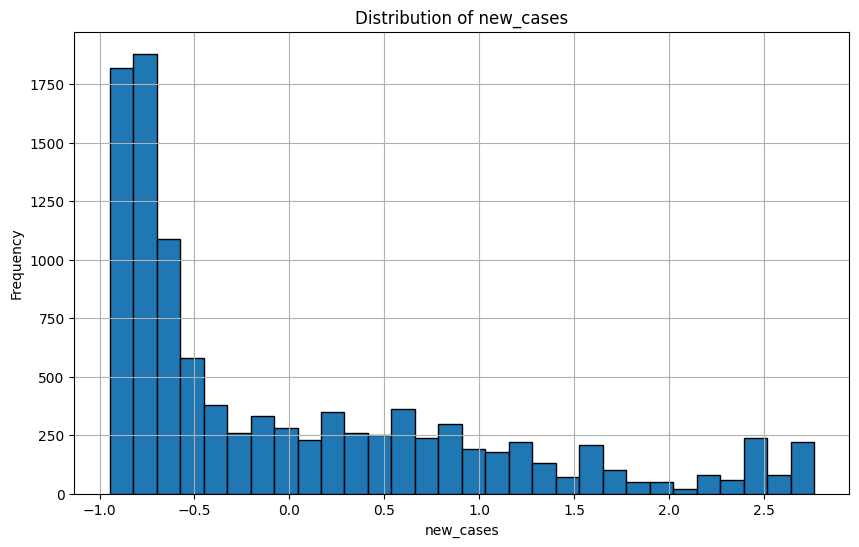

In [79]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'new_cases'

# Plotting the distribution
plt.figure(figsize=(10, 6))
normalized_df[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

### Embedding Layer for Sequential Variables

#### Label Encode first

In [85]:
cleaned_df.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium  -0.946762   -0.965679           0.008569   
2020-03-02  Belgium  -0.947143   -0.965679           0.008569   
2020-03-03  Belgium  -0.946381   -0.965679           4.747404   
2020-03-04  Belgium  -0.945381   -0.960052           4.783007   
2020-03-05  Belgium  -0.944571   -0.965679           4.818610   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01         -1.260718       -0.942306       -0.936442   
2020-03-02         -1.260718       -0.946592       -0.938631   
2020-03-03         -1.260718       -0.946973       -0.930113   
2020-03-04         -1.260718       -0.946211       -0.934015   
2020-03-05         -1.260718       -0.945211       -0.935871   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01             -0.955060            -0.888205              -0.959142   
2020-03-02             -0.957276            -0.890109              -0.960458   
2020-03-03             -0.958813            -0.892276              -0.962049   
2020-03-04             -0.959934            -0.896012              -0.963390   
2020-03-05             -0.960730            -0.900347              -0.964329   

            ...  is_holiday  season day_of_week  weekend  month  year  \
date        ...                                                         
2020-03-01  ...           0  Spring           6        1      3  2020   
2020-03-02  ...           0  Spring           0        0      3  2020   
2020-03-03  ...           0  Spring           1        0      3  2020   
2020-03-04  ...           0  Spring           2        0      3  2020   
2020-03-05  ...           0  Spring           3        0      3  2020   

            quarter  dayofyear  dayofmonth  season_encoded  
date                                                        
2020-03-01        1         61           1               1  
2020-03-02        1         62           2               1  
2020-03-03        1         63           3               1  
2020-03-04        1         64           4               1  
2020-03-05        1         65           5               1  

[5 rows x 21 columns]

In [95]:
from sklearn.preprocessing import LabelEncoder
cleaned_df_encode = cleaned_df.copy()
# label for ordinal
le = LabelEncoder()
cleaned_df_encode['day_of_week_encoded'] = le.fit_transform(cleaned_df_encode['day_of_week'])
cleaned_df_encode['month_encoded'] = le.fit_transform(cleaned_df_encode['month'])
cleaned_df_encode['year_encoded'] = le.fit_transform(cleaned_df_encode['year'])
cleaned_df_encode['quarter_encoded'] = le.fit_transform(cleaned_df_encode['quarter'])
cleaned_df_encode['dayofyear_encoded'] = le.fit_transform(cleaned_df_encode['dayofyear'])
cleaned_df_encode['dayofmonth_encoded'] = le.fit_transform(cleaned_df_encode['dayofmonth'])



In [96]:
cleaned_df_encode.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium  -0.946762   -0.965679           0.008569   
2020-03-02  Belgium  -0.947143   -0.965679           0.008569   
2020-03-03  Belgium  -0.946381   -0.965679           4.747404   
2020-03-04  Belgium  -0.945381   -0.960052           4.783007   
2020-03-05  Belgium  -0.944571   -0.965679           4.818610   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01         -1.260718       -0.942306       -0.936442   
2020-03-02         -1.260718       -0.946592       -0.938631   
2020-03-03         -1.260718       -0.946973       -0.930113   
2020-03-04         -1.260718       -0.946211       -0.934015   
2020-03-05         -1.260718       -0.945211       -0.935871   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01             -0.955060            -0.888205              -0.959142   
2020-03-02             -0.957276            -0.890109              -0.960458   
2020-03-03             -0.958813            -0.892276              -0.962049   
2020-03-04             -0.959934            -0.896012              -0.963390   
2020-03-05             -0.960730            -0.900347              -0.964329   

            ...  quarter  dayofyear dayofmonth  season_encoded  \
date        ...                                                  
2020-03-01  ...        1         61          1               1   
2020-03-02  ...        1         62          2               1   
2020-03-03  ...        1         63          3               1   
2020-03-04  ...        1         64          4               1   
2020-03-05  ...        1         65          5               1   

            day_of_week_encoded  month_encoded  year_encoded  quarter_encoded  \
date                                                                            
2020-03-01                    6              2             0                0   
2020-03-02                    0              2             0                0   
2020-03-03                    1              2             0                0   
2020-03-04                    2              2             0                0   
2020-03-05                    3              2             0                0   

            dayofyear_encoded  dayofmonth_encoded  
date                                               
2020-03-01                 60                   0  
2020-03-02                 61                   1  
2020-03-03                 62                   2  
2020-03-04                 63                   3  
2020-03-05                 64                   4  

[5 rows x 27 columns]

## Tuning Hyper Params

learning_rate 
batch_size 
epochs 
sequence_length 

In [156]:
data_prepped = cleaned_df_encode.copy()
drop = ['season', 'day_of_week', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth']

data_prepped = data_prepped.drop(columns = drop)
data_prepped.head()

location  new_cases  new_deaths  reproduction_rate  \
date                                                            
2020-03-01  Belgium  -0.946762   -0.965679           0.008569   
2020-03-02  Belgium  -0.947143   -0.965679           0.008569   
2020-03-03  Belgium  -0.946381   -0.965679           4.747404   
2020-03-04  Belgium  -0.945381   -0.960052           4.783007   
2020-03-05  Belgium  -0.944571   -0.965679           4.818610   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01         -1.260718       -0.942306       -0.936442   
2020-03-02         -1.260718       -0.946592       -0.938631   
2020-03-03         -1.260718       -0.946973       -0.930113   
2020-03-04         -1.260718       -0.946211       -0.934015   
2020-03-05         -1.260718       -0.945211       -0.935871   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01             -0.955060            -0.888205              -0.959142   
2020-03-02             -0.957276            -0.890109              -0.960458   
2020-03-03             -0.958813            -0.892276              -0.962049   
2020-03-04             -0.959934            -0.896012              -0.963390   
2020-03-05             -0.960730            -0.900347              -0.964329   

            new_cases_roll_std14  is_holiday  weekend  season_encoded  \
date                                                                    
2020-03-01             -0.953350           0        1               1   
2020-03-02             -0.950921           0        0               1   
2020-03-03             -0.954401           0        0               1   
2020-03-04             -0.958744           0        0               1   
2020-03-05             -0.961175           0        0               1   

            day_of_week_encoded  month_encoded  year_encoded  quarter_encoded  \
date                                                                            
2020-03-01                    6              2             0                0   
2020-03-02                    0              2             0                0   
2020-03-03                    1              2             0                0   
2020-03-04                    2              2             0                0   
2020-03-05                    3              2             0                0   

            dayofyear_encoded  dayofmonth_encoded  
date                                               
2020-03-01                 60                   0  
2020-03-02                 61                   1  
2020-03-03                 62                   2  
2020-03-04                 63                   3  
2020-03-05                 64                   4

In [157]:
# Assuming 'location' is a categorical variable
data_prepped['location_encoded'] = le.fit_transform(data_prepped['location'])
data_prepped = data_prepped.drop(columns = ['location'])
data_prepped.head()

new_cases  new_deaths  reproduction_rate  stringency_index  \
date                                                                     
2020-03-01  -0.946762   -0.965679           0.008569         -1.260718   
2020-03-02  -0.947143   -0.965679           0.008569         -1.260718   
2020-03-03  -0.946381   -0.965679           4.747404         -1.260718   
2020-03-04  -0.945381   -0.960052           4.783007         -1.260718   
2020-03-05  -0.944571   -0.965679           4.818610         -1.260718   

            new_cases_lag1  new_cases_lag8  new_cases_roll_mean7  \
date                                                               
2020-03-01       -0.942306       -0.936442             -0.955060   
2020-03-02       -0.946592       -0.938631             -0.957276   
2020-03-03       -0.946973       -0.930113             -0.958813   
2020-03-04       -0.946211       -0.934015             -0.959934   
2020-03-05       -0.945211       -0.935871             -0.960730   

            new_cases_roll_std7  new_cases_roll_mean14  new_cases_roll_std14  \
date                                                                           
2020-03-01            -0.888205              -0.959142             -0.953350   
2020-03-02            -0.890109              -0.960458             -0.950921   
2020-03-03            -0.892276              -0.962049             -0.954401   
2020-03-04            -0.896012              -0.963390             -0.958744   
2020-03-05            -0.900347              -0.964329             -0.961175   

            is_holiday  weekend  season_encoded  day_of_week_encoded  \
date                                                                   
2020-03-01           0        1               1                    6   
2020-03-02           0        0               1                    0   
2020-03-03           0        0               1                    1   
2020-03-04           0        0               1                    2   
2020-03-05           0        0               1                    3   

            month_encoded  year_encoded  quarter_encoded  dayofyear_encoded  \
date                                                                          
2020-03-01              2             0                0                 60   
2020-03-02              2             0                0                 61   
2020-03-03              2             0                0                 62   
2020-03-04              2             0                0                 63   
2020-03-05              2             0                0                 64   

            dayofmonth_encoded  location_encoded  
date                                              
2020-03-01                   0                 0  
2020-03-02                   1                 0  
2020-03-03                   2                 0  
2020-03-04                   3                 0  
2020-03-05                   4                 0

In [131]:
data_prepped.shape

(10510, 20)

In [135]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import scikeras
from scikeras.wrappers import KerasRegressor
import keras

df_encoded = data_prepped.copy()

# Assuming df_encoded is a pandas DataFrame with your time series data
# and 'new_cases' is the target variable.

# Split the data into features (X) and target variable (y)
X = df_encoded.drop('new_cases', axis=1).values
y = df_encoded['new_cases'].values

# Separate non-time-related and time-related variables
non_time_vars = 4
time_vars = 15

X_non_time = X[:, :non_time_vars]
X_time = X[:, non_time_vars:]

# Concatenate the standardized non-time and time variables
X_scaled = np.concatenate((X_non_time, X_time), axis=1)

# Reshape data to 3D for LSTM input (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define your LSTM model as a function
def create_lstm_model(sequence_length=10, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, X_reshaped.shape[2])))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap the Keras model for use with scikit-learn
model = KerasRegressor(build_fn=create_lstm_model, learning_rate = 0.001, epochs=10, 
                       batch_size=32, sequence_length=5, verbose=0)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'sequence_length': [5, 10, 15],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

# Define the time series split
tscv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to your training data
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test score: {test_score}")


/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X,

ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1219" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1220" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1221" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1222" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1223" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1224" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1225" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1226" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1227" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1228" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1229" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1230" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1231" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1232" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1233" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1234" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1235" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1236" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1237" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1238" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1239" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1240" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1241" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1242" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1243" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1244" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1245" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1246" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1247" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1248" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1249" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1250" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1251" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1252" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1253" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1254" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1255" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1256" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1257" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1258" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1259" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1260" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1261" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1262" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1263" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1264" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1265" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1266" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1267" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1268" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1269" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1270" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1271" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1272" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1273" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1274" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1275" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1276" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1277" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1278" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1279" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1280" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1281" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1282" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1283" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1284" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1285" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1286" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1287" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1288" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1289" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1290" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1291" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1292" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1293" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1294" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1295" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1296" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1297" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1298" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1299" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1300" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1301" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1302" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1303" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1304" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1305" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1306" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1307" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1308" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1309" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1310" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1311" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1312" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1313" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1314" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1315" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1316" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1317" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1318" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1319" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1320" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1321" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1322" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1323" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1324" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1325" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1326" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1327" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1328" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1329" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1330" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1331" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1332" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1333" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1334" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1335" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1336" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1337" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1338" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1339" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1340" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1341" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1342" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1343" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1344" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1345" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1346" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1347" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1348" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1349" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1350" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1351" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1352" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1353" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1354" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1355" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1356" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1357" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1358" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1359" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1360" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1361" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1362" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1363" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1364" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1365" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1366" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1367" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1368" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1369" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1370" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1371" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1372" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1373" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1374" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1375" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1376" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1377" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1378" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1379" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1380" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1381" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1382" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1383" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1384" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1385" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1386" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1387" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1388" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1389" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1390" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1391" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1392" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1393" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1394" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1395" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1396" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1397" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1398" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1399" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1400" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1401" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1402" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1403" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1404" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1405" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1406" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1407" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1408" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1409" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1410" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1411" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1412" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1413" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1414" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1415" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1416" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1417" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1418" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1419" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1420" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1421" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1422" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1423" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1424" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1425" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1426" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1427" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1428" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1429" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1430" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1431" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1432" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1433" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1434" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1435" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1436" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1437" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1438" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1439" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1440" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1441" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1442" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1443" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1444" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1445" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1446" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1447" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1448" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1449" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1450" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1451" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1452" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1453" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1454" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1455" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1456" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1457" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1458" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1459" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1460" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1461" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1462" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1463" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1464" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1465" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1466" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1467" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1468" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1469" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1470" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1471" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1472" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1473" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1474" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1475" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1476" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1477" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1478" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1479" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1480" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1481" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1482" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1483" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1484" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1485" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1486" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1487" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1488" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1489" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1490" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1491" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1492" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1493" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1494" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1495" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1496" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1497" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1498" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1499" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1500" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1501" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1502" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1503" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1504" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1505" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1506" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1507" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1508" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1509" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1510" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1511" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1512" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1513" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1514" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1515" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1516" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1517" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1518" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1519" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1520" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1521" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1522" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1523" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1524" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1525" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1526" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1527" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1528" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1529" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1530" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1531" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1532" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1533" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1534" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1535" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1536" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1537" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1538" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1539" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1540" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1541" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1542" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1543" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1544" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1545" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1546" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1547" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1548" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1549" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1550" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1551" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1552" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1553" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1554" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1555" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1556" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1557" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1558" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1559" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1560" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1561" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1562" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1563" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1564" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1565" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1566" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1567" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1568" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1569" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1570" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1571" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1572" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1573" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1574" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1575" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1576" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1577" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1578" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1579" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1580" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1581" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1582" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1583" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1584" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1585" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1586" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1587" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1588" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1589" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1590" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1591" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1592" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1593" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1594" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1595" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1596" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1597" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1598" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1599" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1600" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1601" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1602" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1603" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1604" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1605" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1606" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1607" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1608" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1609" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1610" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1611" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1612" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1613" is incompatible with the layer: expected shape=(None, 5, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1614" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1615" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1616" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1617" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1618" is incompatible with the layer: expected shape=(None, 10, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1619" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1620" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1621" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1622" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/scikeras/wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/__autograph_generated_file2nateb_x.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timhong/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1623" is incompatible with the layer: expected shape=(None, 15, 19), found shape=(None, 1, 19)



In [158]:
data_prepped = data_prepped[data_prepped.columns[-1:].tolist() + data_prepped.columns[:-1].tolist()]
data_prepped = data_prepped[data_prepped.columns[1:2].tolist() + data_prepped.columns[0:1].tolist() + data_prepped.columns[2:].tolist()]
data_prepped.head()

new_cases  location_encoded  new_deaths  reproduction_rate  \
date                                                                     
2020-03-01  -0.946762                 0   -0.965679           0.008569   
2020-03-02  -0.947143                 0   -0.965679           0.008569   
2020-03-03  -0.946381                 0   -0.965679           4.747404   
2020-03-04  -0.945381                 0   -0.960052           4.783007   
2020-03-05  -0.944571                 0   -0.965679           4.818610   

            stringency_index  new_cases_lag1  new_cases_lag8  \
date                                                           
2020-03-01         -1.260718       -0.942306       -0.936442   
2020-03-02         -1.260718       -0.946592       -0.938631   
2020-03-03         -1.260718       -0.946973       -0.930113   
2020-03-04         -1.260718       -0.946211       -0.934015   
2020-03-05         -1.260718       -0.945211       -0.935871   

            new_cases_roll_mean7  new_cases_roll_std7  new_cases_roll_mean14  \
date                                                                           
2020-03-01             -0.955060            -0.888205              -0.959142   
2020-03-02             -0.957276            -0.890109              -0.960458   
2020-03-03             -0.958813            -0.892276              -0.962049   
2020-03-04             -0.959934            -0.896012              -0.963390   
2020-03-05             -0.960730            -0.900347              -0.964329   

            new_cases_roll_std14  is_holiday  weekend  season_encoded  \
date                                                                    
2020-03-01             -0.953350           0        1               1   
2020-03-02             -0.950921           0        0               1   
2020-03-03             -0.954401           0        0               1   
2020-03-04             -0.958744           0        0               1   
2020-03-05             -0.961175           0        0               1   

            day_of_week_encoded  month_encoded  year_encoded  quarter_encoded  \
date                                                                            
2020-03-01                    6              2             0                0   
2020-03-02                    0              2             0                0   
2020-03-03                    1              2             0                0   
2020-03-04                    2              2             0                0   
2020-03-05                    3              2             0                0   

            dayofyear_encoded  dayofmonth_encoded  
date                                               
2020-03-01                 60                   0  
2020-03-02                 61                   1  
2020-03-03                 62                   2  
2020-03-04                 63                   3  
2020-03-05                 64                   4

In [164]:
# manupulate data for LSTM
df_encoded = data_prepped.copy()
def make_series(data):
    series = []
    for i in range(len(data)-14):
        sub_seq = data[i:i+14]
        series.append((sub_seq.index[-1], sub_seq['new_cases'].values[-1], sub_seq.drop('new_cases', axis=1).values))
    return series

df_series = make_series(df_encoded)
print(df_series[0][0],df_series[0][1].shape,df_series[0][2].shape)
train = df_series[:-14]
test = df_series[-14:]



2020-03-14 00:00:00 () (14, 19)


[(Timestamp('2020-03-14 00:00:00'),
  -0.9242826467231107,
  array([[ 0.00000000e+00, -9.65678600e-01,  8.56915227e-03,
          -1.26071848e+00, -9.42306470e-01, -9.36442124e-01,
          -9.55060444e-01, -8.88204760e-01, -9.59141642e-01,
          -9.53350412e-01,  0.00000000e+00,  1.00000000e+00,
           1.00000000e+00,  6.00000000e+00,  2.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  6.00000000e+01,
           0.00000000e+00],
         [ 0.00000000e+00, -9.65678600e-01,  8.56915227e-03,
          -1.26071848e+00, -9.46592459e-01, -9.38631036e-01,
          -9.57275789e-01, -8.90108673e-01, -9.60457587e-01,
          -9.50921078e-01,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00,  0.00000000e+00,  2.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  6.10000000e+01,
           1.00000000e+00],
         [ 0.00000000e+00, -9.65678600e-01,  4.74740394e+00,
          -1.26071848e+00, -9.46973436e-01, -9.30113311e-01,
          -9.58812685e-01, -8.9

In [163]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming data_prepped is your feature matrix and new_cases is the target variable
# Replace 'data_prepped' and 'new_cases' with your actual variables

# Set the random seed for reproducibility
np.random.seed(42)


# Assuming df_encoded is a pandas DataFrame with your time series data
# and 'new_cases' is the target variable.

# Split the data into features (X) and target variable (y)

# Define hyperparameter values to search
learning_rates = [0.001, 0.01, 0.1]
n_units = [32, 64, 128]
early_stopping_patience = [5, 10, 15]
sequence_lengths = [5, 10, 15]
batch_sizes = [16, 32, 64]
n_epochs = [10, 20, 30]

# Initialize variables to store the best hyperparameter values and test loss
best_hyperparams = {
    'learning_rate': None,
    'batch_size': None,
    'n_units': None,
    'patience': None,
    'sequence_length': None,
    'epochs': None
}
best_test_loss = float('inf')

# grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for n_unit in n_units:
            for patience in early_stopping_patience:
                for sequence_length in sequence_lengths:
                    for n_epoch in n_epochs:
                        print('Learning rate: {}, Batch size: {}, LSTM units: {}, Early stopping patience: {}, Sequence length: {}, Epochs: {}'.format(lr, bs, n_unit, patience, sequence_length, n_epoch))
                        
                        # Build and compile the model
                        model = Sequential()
                        model.add(LSTM(units=n_unit, input_shape=(sequence_length, train.shape[1])))
                        model.add(Dropout(0.2))
                        model.add(Dense(units=1))
                        model.compile(optimizer='adam', loss='mean_squared_error')

                        # Set up early stopping
                        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

                        # Fit the model
                        history = model.fit(train, epochs=n_epoch, batch_size=bs, validation_split=0.01332065, callbacks=[early_stopping], verbose=0)

                        # Evaluate the model on the test set
                        test_loss = model.evaluate(test, verbose=0)

                        print('Test Loss:', test_loss)

                        # Check if the current model has the best test loss
                        if test_loss < best_test_loss:
                            best_test_loss = test_loss
                            best_hyperparams = {
                                'learning_rate': lr,
                                'batch_size': bs,
                                'n_units': n_unit,
                                'patience': patience,
                                'sequence_length': sequence_length,
                                'epochs': n_epoch
                            }

# Print the best hyperparameter values and test loss
print('\nBest Hyperparameter Values:')
for param, value in best_hyperparams.items():
    print(f'{param}: {value}')
print('Best Test Loss:', best_test_loss)


Learning rate: 0.001, Batch size: 16, LSTM units: 32, Early stopping patience: 5, Sequence length: 5, Epochs: 10


AttributeError: 'list' object has no attribute 'shape'

In [162]:
# manupulate data for LSTM
df_encoded = data_prepped.copy()
def make_series(data):
    series = []
    for i in range(len(data)-14):
        sub_seq = data[i:i+14]
        series.append((sub_seq.index[-1], sub_seq['new_cases'].values[-1], sub_seq.drop('new_cases', axis=1).values))
    return series

df_series = make_series(df_encoded)
print(df_series[0][0],df_series[0][1].shape,df_series[0][2].shape)
train = df_series[:-14]
test = df_series[-14:]


2020-03-14 00:00:00 () (14, 19)


In [169]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

inputs = keras.layers.Input(shape=(14,19))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 19)]          0         
                                                                 
 lstm_1627 (LSTM)            (None, 32)                6656      
                                                                 
 dense_1626 (Dense)          (None, 1)                 33        
                                                                 
Total params: 6689 (26.13 KB)
Trainable params: 6689 (26.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [170]:
x=np.array([x[2].reshape(14,19) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(10482, 14, 19)
(10482,)
Epoch 1/100
328/328 [==============================] - 2s 2ms/step - loss: 0.1146
Epoch 2/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0364
Epoch 3/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0279
Epoch 4/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0266
Epoch 5/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0275
Epoch 6/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0237
Epoch 7/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0232
Epoch 8/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0195
Epoch 9/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 10/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0204
Epoch 11/100
328/328 [==============================] - 1s 2ms/step - loss: 0.0197
Epoch 12/100
328/328 [==============================] - 1s 2ms/step - l

328/328 [==============================] - 0s 640us/step


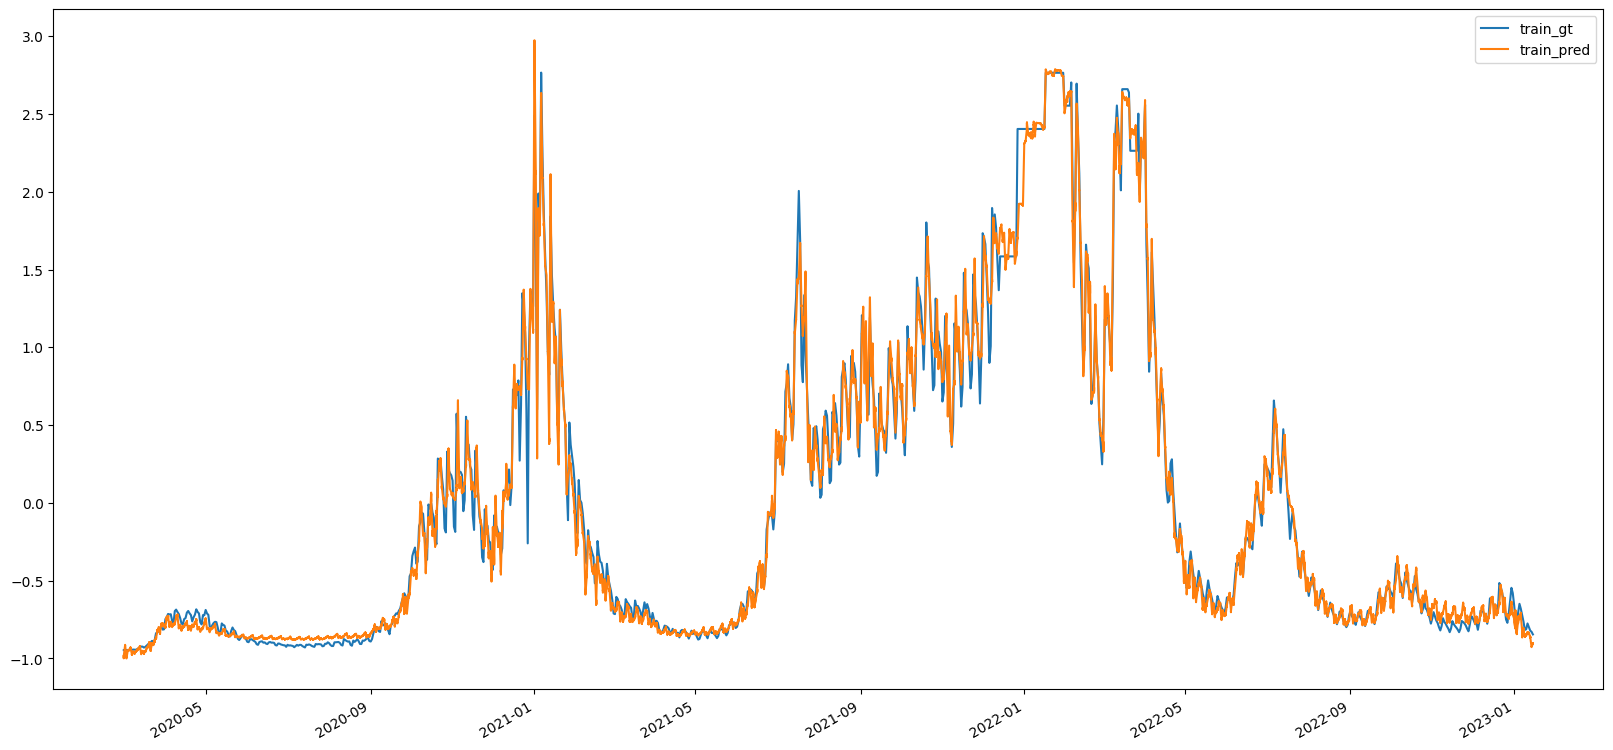

In [172]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

1/1 [==============================] - 0s 12ms/step


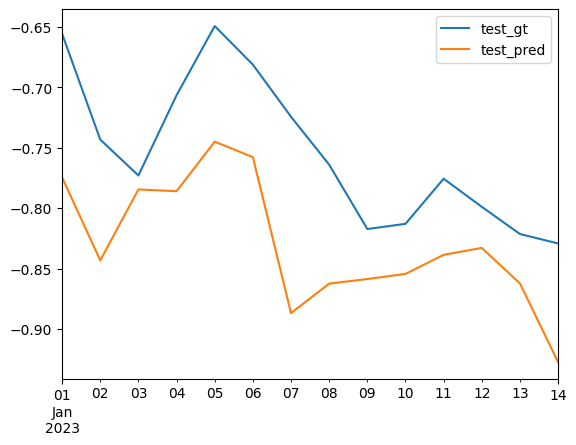

In [174]:
test_pred=model.predict(np.array([x[2].reshape(14,19) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])